 # 1. Bitcoin Data Preparation
 
 ## Principles & data sources
 
We first use historical data from financial data as our data inputs. For this, we are going to use yfinance library, that scrapes this data from Yahoo Finance, returning it as a pandas dataframe, which will facilitate most of this work, and also we'll use quandl.

We use Yahoo Bitcoin History, the data is free to download.
We are also using US Dollar Index Futures Historical Data and the 10 years treasury bill. The U.S. Dollar Index (USDX, DXY, DX, or, informally, the "Dixie") is an index (or measure) of the value of the United States dollar relative to a basket of foreign currencies,often referred to as a basket of U.S. trade partners currencies. The Index goes up when the U.S. dollar gains "strength" (value) when compared to other currencies. https://en.wikipedia.org/wiki/U.S._Dollar_Index.

The data are:
* Historical financial data <b>(Btc, 	crude oil, 	Dixie, Treasury_Yield_10Years_Index, 	euro,	gold, 	silver,	ftse,	hsi, 	nasdaq,	nikkei, shangai)</b>. To make stock prices comparable, we bring all of them into the same base. For this, we will use the daily returns of holding this stock. This way, instead of comparing stocks with different prices (for example, Nikkei starting at 10k USD vs FTSE at 5k USD) we will bring all of them to the base of one at the start of the timeframe and record their daily increase or decrease in % to that base.
* Fundamental Bitcoin's blockchain data are also be included, such as hashrate, mining difficulty, (daily) number of transactions and cost per transaction.
* aditionally several indicators typically used in technical analysis of stock prices, such as simple moving averages, the (stochastic) relative strength index and other statistical measures s.a. the expanding standard deviation of Bitcoin price.
* buy, sell and no-trade signals. For this, the condition for the labels will be that if price goes up by more than a certain confidence level it's a buy, down a certain confidence level or less a sell, and values in between labelled as no-trade zone.

In [1]:
#%pip install yfinance quandl   # Optional

In [2]:
# importing commonly used libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Dixie >> The U.S. Dollar Index (USDX, DXY, DX, or, informally, the "Dixie") is an index (or measure) of the value of the United States dollar relative to a basket of foreign currencies,often referred to as a basket of U.S. trade partners currencies. The Index goes up when the U.S. dollar gains "strength" (value) when compared to other currencies. https://en.wikipedia.org/wiki/U.S._Dollar_Index

In [3]:
tickers = ['SPY','^IXIC', 'GC=F', 'SI=F','CL=F', '^TNX',
           'BTC-USD','DX-Y.NYB','^N225','^ftse', 'EURUSD=X','000001.SS', '^HSI']
signs = ['=','^','-','.']
ma_values = [4,96,200]
rsi_values = {
    'k': 3,
    'd': 3,
    'alpha':14
}

def change_name(ticker):
    if ticker == 'tnx':
        x = 'Treasury_Yield_10Years_Index'
    elif ticker == 'sif':
        x = 'silver'
    elif ticker == 'gcf':
        x = 'gold'
    elif ticker == 'ixic':
        x = 'nasdaq'
    elif ticker == 'clf':
        x = 'crude oil'
    elif ticker == 'btcusd':
        x = 'btc'
    elif ticker == 'dxynyb':
        x = 'dixie'
    elif ticker == 'n225':
        x = 'nikkei'
    elif ticker == 'eurusdx':
        x = 'euro'
    elif ticker == '000001ss':
        x = 'shangai'
    elif ticker == 'spy':
        x = 'S&P'
    else:
        x = ticker
    return x

def lower_clean_name(word, signs):
    word = word.lower()
    for char in signs: 
        word = word.replace(char, '')
    return word

# test change labels amongst indices

labels = [lower_clean_name(word,signs) for word in tickers]
changed_labels = [change_name(x) for x in labels]

for x in range(len(labels)):
    print(labels[x] +' = '+changed_labels[x])

spy = S&P
ixic = nasdaq
gcf = gold
sif = silver
clf = crude oil
tnx = Treasury_Yield_10Years_Index
btcusd = btc
dxynyb = dixie
n225 = nikkei
ftse = ftse
eurusdx = euro
000001ss = shangai
hsi = hsi


In [4]:
ticker_concat = " ".join(tickers)
data_ohlc = yf.download(ticker_concat, start="2008-01-01")
data_ohlc.tail()    # data_ohlc.shape # (3515, 78)

[*********************100%***********************]  13 of 13 completed


Adj Close                                                \
              000001.SS       BTC-USD       CL=F   DX-Y.NYB  EURUSD=X   
Date                                                                    
2021-06-17  3525.600098  38053.503906  71.040001  91.889999  1.199559   
2021-06-18  3525.100098  35787.246094  71.639999  92.230003  1.191341   
2021-06-19          NaN  35615.871094        NaN        NaN       NaN   
2021-06-20          NaN  35698.296875        NaN        NaN       NaN   
2021-06-21  3519.493652  34460.886719  71.900002  92.268997  1.187085   

                                                                           \
                   GC=F       SI=F         SPY        ^FTSE          ^HSI   
Date                                                                        
2021-06-17  1773.800049  25.844000  421.970001  7153.399902  28558.589844   
2021-06-18  1767.900024  25.958000  414.920013  7017.500000  28801.269531   
2021-06-19          NaN        NaN         NaN          NaN           NaN   
2021-06-20          NaN        NaN         NaN          NaN           NaN   
2021-06-21  1769.699951  25.639999         NaN          NaN  28355.289062   

                                                     Close                \
                   ^IXIC         ^N225   ^TNX    000001.SS       BTC-USD   
Date                                                                       
2021-06-17  14161.349609  29018.330078  1.511  3525.600098  38053.503906   
2021-06-18  14030.379883  28964.080078  1.450  3525.100098  35787.246094   
2021-06-19           NaN           NaN    NaN          NaN  35615.871094   
2021-06-20           NaN           NaN    NaN          NaN  35698.296875   
2021-06-21           NaN  27885.990234    NaN  3519.493652  34460.886719   

                                                                    \
                 CL=F   DX-Y.NYB  EURUSD=X         GC=F       SI=F   
Date                                                                 
2021-06-17  71.040001  91.889999  1.199559  1773.800049  25.844000   
2021-06-18  71.639999  92.230003  1.191341  1767.900024  25.958000   
2021-06-19        NaN        NaN       NaN          NaN        NaN   
2021-06-20        NaN        NaN       NaN          NaN        NaN   
2021-06-21  71.900002  92.268997  1.187085  1769.699951  25.639999   

                                                                               \
                   SPY        ^FTSE          ^HSI         ^IXIC         ^N225   
Date                                                                            
2021-06-17  421.970001  7153.399902  28558.589844  14161.349609  29018.330078   
2021-06-18  414.920013  7017.500000  28801.269531  14030.379883  28964.080078   
2021-06-19         NaN          NaN           NaN           NaN           NaN   
2021-06-20         NaN          NaN           NaN           NaN           NaN   
2021-06-21         NaN          NaN  28355.289062           NaN  27885.990234   

                          High                                                \
             ^TNX    000001.SS       BTC-USD       CL=F   DX-Y.NYB  EURUSD=X   
Date                                                                           
2021-06-17  1.511  3534.199951  39513.671875  72.300003  92.010002  1.200769   
2021-06-18  1.450  3535.620117  38187.261719  72.169998  92.410004  1.192748   
2021-06-19    NaN          NaN  36457.796875        NaN        NaN       NaN   
2021-06-20    NaN          NaN  36059.484375        NaN        NaN       NaN   
2021-06-21    NaN  3540.295898  35687.859375  72.410004  92.364998  1.188213   

                                                                        \
                   GC=F    SI=F         SPY        ^FTSE          ^HSI   
Date                                                                     
2021-06-17  1823.300049  25.844  423.019989  7185.000000  28558.589844   
2021-06-18  1792.400024  26.430  417.829987  7154.600098

In [5]:
data_ticker = yf.download(ticker_concat, start="2008-01-01", group_by='tickers') #regroup per Ticker []
data_ticker.tail()  
#data_ticker['BTC-USD':].tail()

[*********************100%***********************]  13 of 13 completed


GC=F                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2021-06-17  1811.800049  1823.300049  1769.599976  1773.800049  1773.800049   
2021-06-18  1775.699951  1792.400024  1767.900024  1767.900024  1767.900024   
2021-06-19          NaN          NaN          NaN          NaN          NaN   
2021-06-20          NaN          NaN          NaN          NaN          NaN   
2021-06-21  1764.300049  1777.000000  1764.099976  1769.699951  1769.699951   

                           ^FTSE                                         \
             Volume         Open         High          Low        Close   
Date                                                                      
2021-06-17   1135.0  7185.000000  7185.000000  7133.000000  7153.399902   
2021-06-18   1135.0  7153.399902  7154.600098  7008.700195  7017.500000   
2021-06-19      NaN          NaN          NaN          NaN          NaN   
2021-06-20      NaN          NaN          NaN          NaN          NaN   
2021-06-21  38484.0          NaN          NaN          NaN          NaN   

                                            SI=F                          \
              Adj Close        Volume       Open    High     Low   Close   
Date                                                                       
2021-06-17  7153.399902  7.246799e+08  25.844000  25.844  25.844  25.844   
2021-06-18  7017.500000  1.553511e+09  26.424999  26.430  25.958  25.958   
2021-06-19          NaN           NaN        NaN     NaN     NaN     NaN   
2021-06-20          NaN           NaN        NaN     NaN     NaN     NaN   
2021-06-21          NaN           NaN  25.865000  26.055  25.580  25.635   

                                      ^IXIC                              \
           Adj Close   Volume          Open          High           Low   
Date                                                                      
2021-06-17    25.844     51.0  13999.129883  14196.209961  13998.929688   
2021-06-18    25.958     51.0  14096.929688  14129.219727  14009.040039   
2021-06-19       NaN      NaN           NaN           NaN           NaN   
2021-06-20       NaN      NaN           NaN           NaN           NaN   
2021-06-21    25.635  13455.0           NaN           NaN           NaN   

                                                             ^N225  \
                   Close     Adj Close        Volume          Open   
Date                                                                 
2021-06-17  14161.349609  14161.349609  4.526780e+09  29149.339844   
2021-06-18  14030.379883  14030.379883  6.105960e+09  29136.740234   
2021-06-19           NaN           NaN           NaN           NaN   
2021-06-20           NaN           NaN           NaN           NaN   
2021-06-21           NaN           NaN           NaN  28506.839844   

                                                                    \
                    High           Low         Close     Adj Close   
Date                                                                 
2021-06-17  29197.679688  28875.390625  29018.330078  29018.330078   
2021-06-18  29136.740234  28957.980469  28964.080078  28964.080078   
2021-06-19           NaN           NaN           NaN           NaN   
2021-06-20           NaN           NaN           NaN           NaN   
2021-06-21  28506.839844  27795.859375  27888.009766  27888.009766   

                             CL=F                                              \
                Volume       Open       High        Low      Close  Adj Close   
Date                                                                            
2021-06-17  56900000.0  71.650002  72.300003  69.769997  71.040001  71.040001   
2021-06-18  90200000.0  71.099998  72.169998  70.160004  71.639999  71.639999   
2021-06-19         NaN        NaN        NaN    

### Forming our basic set named 'close'

In [6]:
close = data_ohlc['Close'].fillna(method='ffill')     #select only the closing values for the 13 tickers
close.rename(columns = lambda x: change_name(lower_clean_name(x,signs)), inplace=True) # Renaming columns to changed labels
btcdata = data_ticker['BTC-USD'].fillna(method='ffill') #select only the BTC daily data
btcdata.drop(columns={'Adj Close'}, inplace=True)
close = pd.concat([btcdata, close], axis=1) # adding bitcoin 
close = close[close.btc.notnull()]     # Eliminate the first line where there is no BTC
# close.to_csv('data/L3_Data_v1_13dim_17xx.csv')
close.tail()   #close.columns

,Open,High,Low,Close,Volume,shangai,btc,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index
Date,,,,,,,,,,,,,,,,,,
2021-06-17,38341.421875,39513.671875,37439.675781,38053.503906,3.709667e+10,3525.600098,38053.503906,71.040001,91.889999,1.199559,1773.800049,25.844000,421.970001,7153.399902,28558.589844,14161.349609,29018.330078,1.511
2021-06-18,38099.476562,38187.261719,35255.855469,35787.246094,3.620089e+10,3525.100098,35787.246094,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450
2021-06-19,35854.527344,36457.796875,34933.062500,35615.871094,3.120728e+10,3525.100098,35615.871094,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450
2021-06-20,35563.140625,36059.484375,33432.074219,35698.296875,3.666403e+10,3525.100098,35698.296875,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450
2021-06-21,35687.859375,35687.859375,33892.687500,34460.886719,3.851328e+10,3519.493652,34460.886719,71.900002,92.268997,1.187085,1769.699951,25.639999,414.920013,7017.500000,28355.289062,14030.379883,27885.990234,1.450


In [7]:
close.shape

(2470, 18)

# Returns and cumulative returns

To make stock prices comparable, we first need to bring all of them into the same base. For this, we will use the daily returns of holding this stock. This way, instead of comparing stocks with different prices (for example, Nikkei starting at 10k USD vs FTSE at 5k USD) we will bring all of them to the base of one at the start of the timeframe and record their daily increase or decrease in % to that base.
Note:  DataFrame.cumprod(axis=None, skipna=True, *args, **kwargs) returns the cumulative product over a DataFrame or Series axis.

In [8]:
returns = close.pct_change(1) #Percentage of change
returns.tail()

,Open,High,Low,Close,Volume,shangai,btc,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index
Date,,,,,,,,,,,,,,,,,,
2021-06-17,-0.045490,-0.024758,-0.019289,-0.007655,-0.053937,0.002066,-0.007655,-0.015385,0.008340,-0.010844,-0.046088,-0.070360,-0.000332,-0.004398,0.004281,0.008666,-0.009309,-0.036966
2021-06-18,-0.006310,-0.033568,-0.058329,-0.059555,-0.024147,-0.000142,-0.059555,0.008446,0.003700,-0.006850,-0.003326,0.004411,-0.016707,-0.018998,0.008498,-0.009248,-0.001870,-0.040371
2021-06-19,-0.058923,-0.045289,-0.009156,-0.004789,-0.137942,0.000000,-0.004789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-06-20,-0.008127,-0.010925,-0.042968,0.002314,0.174855,0.000000,0.002314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-06-21,0.003507,-0.010306,0.013778,-0.034663,0.050438,-0.001590,-0.034663,0.003629,0.000423,-0.003573,0.001018,-0.012251,0.000000,0.000000,-0.015485,0.000000,-0.037222,0.000000


In [9]:
cumulative = (1 + returns).cumprod() #Return cumulative product over a DataFrame 
cumulative.tail()

,Open,High,Low,Close,Volume,shangai,btc,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index
Date,,,,,,,,,,,,,,,,,,
2021-06-17,82.301746,84.399541,82.753880,83.207246,1761.743002,1.527627,83.207246,0.752383,1.084888,0.925651,1.436973,1.384772,2.101968,1.054934,1.171567,3.104068,1.826354,0.581154
2021-06-18,81.782399,81.566385,77.926926,78.251879,1719.201744,1.527410,78.251879,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692
2021-06-19,76.963505,77.872321,77.213448,77.877153,1482.052340,1.527410,77.877153,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692
2021-06-20,76.338029,77.021542,73.895775,78.057384,1741.196861,1.527410,78.057384,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692
2021-06-21,76.605744,76.227767,74.913881,75.351681,1829.018606,1.524981,75.351681,0.761491,1.089362,0.916026,1.433652,1.373841,2.066849,1.034892,1.163227,3.075361,1.755087,0.557692


<AxesSubplot:title={'center':'Price comparison of assets, without BTC [$]'}, xlabel='Date'>

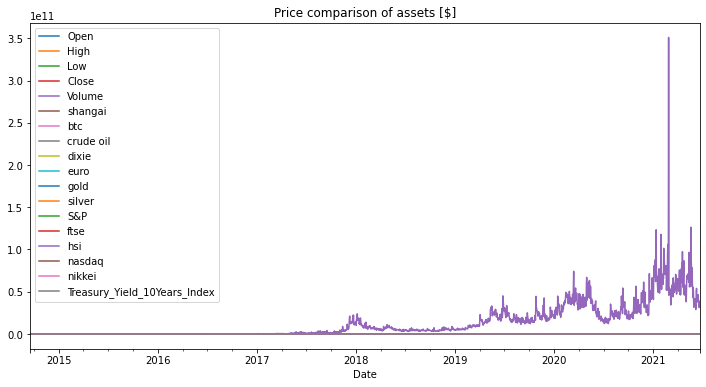

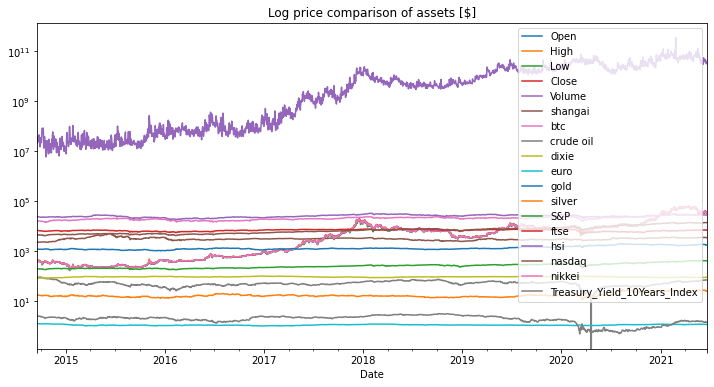

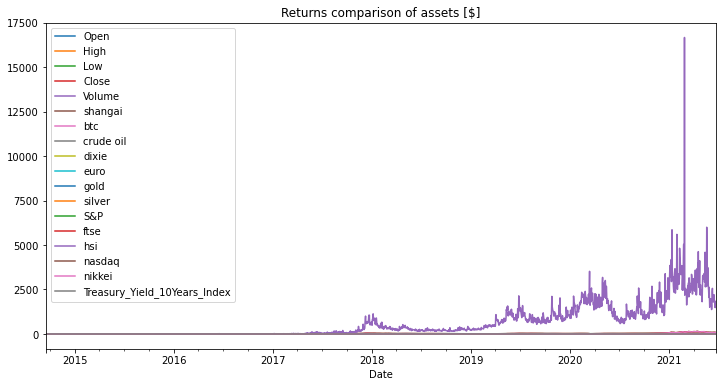

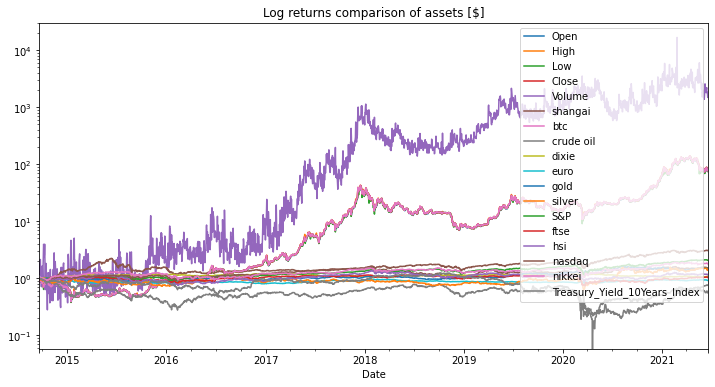

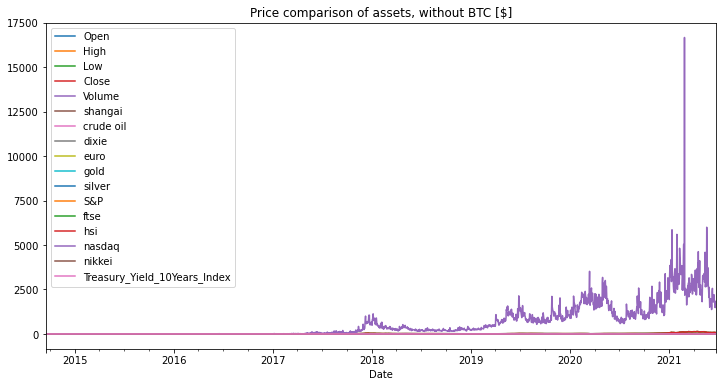

In [10]:
close.plot(figsize=(12,6),label='Price', title='Price comparison of assets [$]')
close.plot(figsize=(12,6),label='Price (log scale)', logy=True, title='Log price comparison of assets [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns', title='Returns comparison of assets [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns (log)', logy=True, title='Log returns comparison of assets [$]')
cumulative.loc[:,cumulative.columns != 'btc'].plot(
    figsize=(12,6), label='Cumulative Returns', title='Price comparison of assets, without BTC [$]')

## Performing technical analysis calculations

Now we will calculate several indicators typically used in technical analysis of stock prices, such as simple moving averages, the (stochastic) relative strength index and other statistical measures s.a. the expanding standard deviation of Bitcoin price.

#### Moving Averages

In [11]:
def transform_ma(data, ma1=4, ma2=96, ma3=200):
    data['MA'+str(ma1)] = round(data['Close'].rolling(ma1).mean(),0)
    data['MA'+str(ma2)] = round(data['Close'].rolling(ma2).mean(),0)
    data['MA'+str(ma3)] = round(data['Close'].rolling(ma3).mean(),0)    
    return data

#### (Stochastic) Relative Strenght Index
The term stochastic refers to the point of a current price in relation to its price range over a period of time.

In [12]:
def transform_rsi(data, alpha=14, smoothK=3, smoothD=3):
    
    data['change'] = data['Close'].pct_change(1)
    data['cum_change'] = (data['change']+1).cumprod()
    data['k'] = 0
    data['d'] = 0

    cond_k = data.change > 0
    cond_d = data.change < 0

    data['k'] = data.k.mask(cond_k, data['change'])
    data['d'] = data.d.mask(cond_d, - data['change'])
    # data['num'] = data['k'].rolling(alpha).mean()
    
    data['num'] = pd.Series.ewm(data['k'], span=alpha).mean()
    data['div'] = pd.Series.ewm(data['d'], span=alpha).mean()
    
    # data['div'] = data['d'].rolling(alpha).mean()
    data['rs'] = data['num']/data['div']
    data['RSI'] = (100 - (100/(1+data['rs'])))
    data['RSImin'] = data['RSI'].rolling(alpha).min()
    data['RSImax'] = data['RSI'].rolling(alpha).max()
    data['stochRSI'] = 100*(data['RSI'] - data['RSImin']) / (data['RSImax'] - data['RSImin'])
    data['smoothK'] = round(data['stochRSI'].rolling(smoothK).mean(),2)
    data['smoothD'] = round(data['smoothK'].rolling(smoothD).mean(),2)
    data['K1'] = data['smoothK'].shift(1)
    data['D1'] = data['smoothD'].shift(1)

    # cond_num_zero = data.num == 0
    # data['RSI'] = data.RSI.mask(cond_num_zero, 0)

    # cond_div_zero = data.div == 0
    # data['RSI'] = data.RSI.mask(cond_div_zero, 100)

    return data

def transform_std(df, confidence=80):
    df['btc_std_dev'] = df['change'].expanding(2).std()
    df['btc_mean'] = df['change'].expanding(2).mean()
    # df['conf_int_p'] = np.percentile(df['change'], (100-confidence)/2)
    # df['conf_int_m'] = np.percentile(df['change'], confidence + (100-confidence)/2)
    df['std_dif'] = (df['Close'] - df['btc_std_dev']).abs()

    return df

In [13]:
btc = data_ticker['BTC-USD'] # Select only the ticker 'BTC-USD' to calculate MM, RSI ...
btc = btc[btc.Close.notnull()]
btc = transform_std(transform_rsi(transform_ma(btc, ma_values[0], ma_values[1], ma_values[2])))
btc.head()

,Open,High,Low,Close,Adj Close,Volume,MA4,MA96,MA200,change,cum_change,k,d,num,div,rs,RSI,RSImin,RSImax,stochRSI,smoothK,smoothD,K1,D1,btc_std_dev,btc_mean,std_dif
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,NaN,NaN,NaN,-0.071926,0.928074,0.000000,0.071926,0.000000,0.038532,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,NaN,NaN,NaN,-0.069843,0.863255,0.000000,0.069843,0.000000,0.050492,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001473,-0.070884,394.794517
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,421.0,NaN,NaN,0.035735,0.894104,0.035735,0.000000,0.010932,0.035045,0.311947,23.777418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061565,-0.035344,408.842426
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,407.0,NaN,NaN,-0.024659,0.872056,0.000000,0.024659,0.008080,0.032335,0.249883,19.992515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050551,-0.032673,398.770463


In [14]:
btc.describe()

,Open,High,Low,Close,Adj Close,Volume,MA4,MA96,MA200,change,cum_change,k,d,num,div,rs,RSI,RSImin,RSImax,stochRSI,smoothK,smoothD,K1,D1,btc_std_dev,btc_mean,std_dif
count,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2.466000e+03,2463.000000,2371.000000,2267.000000,2465.000000,2465.000000,2466.000000,2466.000000,2466.000000,2466.000000,2465.000000,2465.000000,2452.000000,2452.000000,2452.000000,2450.000000,2448.000000,2449.000000,2447.000000,2464.000000,2464.000000,2464.000000
mean,7816.053529,8039.823978,7568.337563,7828.734176,7828.734176,1.279279e+10,7816.647178,7247.837621,6449.503749,0.002533,17.124737,0.014068,0.011536,0.014059,0.011550,2.013259,55.438829,37.910272,71.831322,52.394841,52.405906,52.423721,52.418195,52.432726,0.037356,0.001215,7834.693449
std,11862.139363,12235.067037,11419.462172,11871.199370,11871.199370,1.979123e+10,11847.716363,10464.093188,7810.100445,0.039245,25.960630,0.025273,0.024002,0.009068,0.008674,3.086783,17.952343,15.746565,14.225402,35.253327,31.810377,30.349158,31.811056,30.352091,0.003192,0.002893,11874.149745
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06,199.000000,237.000000,246.000000,-0.371695,0.389437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.604388,0.000000,0.000000,0.000000,0.000000,0.000000,0.001473,-0.070884,178.061070
25%,465.372009,471.364494,456.904762,465.513008,465.513008,6.909980e+07,468.500000,588.500000,574.500000,-0.012627,1.019144,0.000000,0.000000,0.007263,0.005262,0.748371,42.803902,26.385350,60.989844,20.676764,23.205000,24.157500,23.220000,24.155000,0.035025,0.000685,471.587071
50%,4370.705078,4449.790039,4251.300049,4374.064941,4374.064941,4.069515e+09,4372.000000,4904.000000,5460.000000,0.001988,9.569657,0.001976,0.000000,0.011888,0.009145,1.203682,54.621394,37.518910,71.593085,52.244038,52.925000,52.485000,52.950000,52.500000,0.038590,0.002193,4376.545287
75%,9246.804688,9399.840576,9089.138428,9250.451172,9250.451172,1.911901e+10,9250.000000,8922.000000,8883.000000,0.018014,20.230897,0.018005,0.012621,0.019043,0.015769,2.178231,68.535953,48.551392,84.332041,86.446753,82.400000,80.850000,82.410000,80.870000,0.039159,0.002557,9253.206016
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11,62875.000000,54511.000000,43154.000000,0.252472,138.855749,0.252472,0.371695,0.078900,0.063441,62.372352,98.422025,81.462209,98.422025,100.000000,100.000000,100.000000,100.000000,100.000000,0.061565,0.003865,63503.418201


<AxesSubplot:title={'center':'Standard deviation of daily change'}, xlabel='Date'>

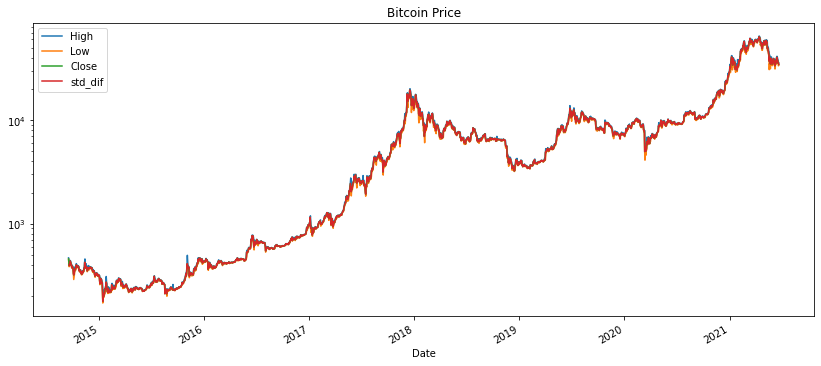

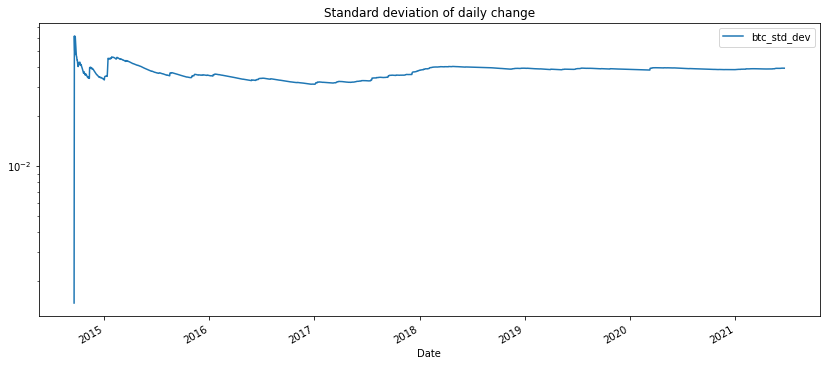

In [15]:
btc[['High','Low','Close','std_dif']].plot(figsize=(14,6),logy=True, title='Bitcoin Price')
btc[['btc_std_dev']].plot(figsize=(14,6), title='Standard deviation of daily change',logy=True)

In [16]:
# Initial selection of features to the model
btc = btc[[f'MA{ma_values[0]}',f'MA{ma_values[1]}', f'MA{ma_values[2]}', 'stochRSI', 'RSI','btc_std_dev','std_dif']].fillna(method='bfill')

In [17]:
data = pd.concat([cumulative, btc], axis=1)
data.drop(data.index[0], inplace=True)
# data

## Getting fundamental Bitcoin data
Fundamental Bitcoin's blockchain data will also be included, such as hashrate, mining difficulty, (daily) number of transactions and cost per transaction.

### Note : to be added >> Bitcoin Halving Schedule
The Bitcoin halving is scheduled in block height, not date.
The halving happens every 210,000 blocks. The 2024 halving will happen on block 840,000. 

<AxesSubplot:xlabel='Date'>

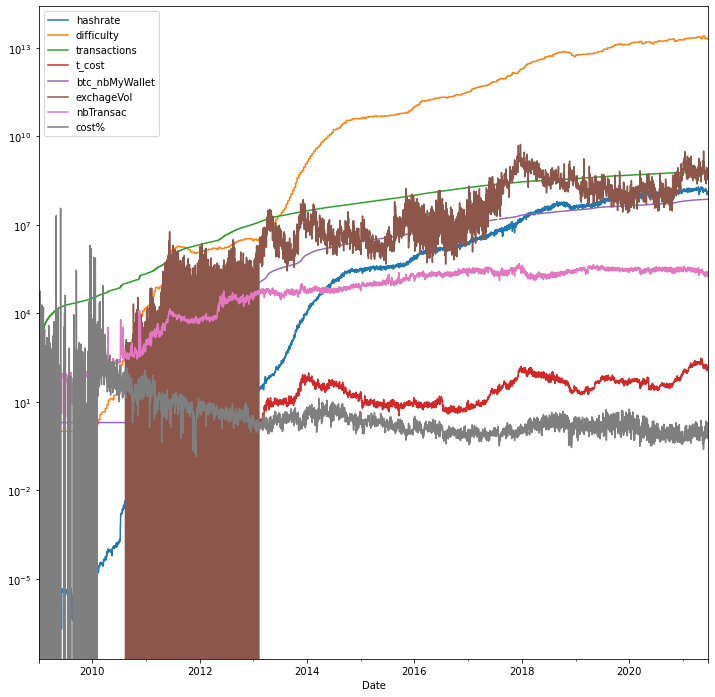

In [18]:
import quandl
# JdFzN65ctuxHPYj
quandl.ApiConfig.api_key = 'SCno4AESxSuXjKdVuC_s' # (insert if available, else there is a ratelimit)
# btc mining is an interesting source, but free data has not the same quality ;)
# btcmining = quandl.get('BITCOINWATCH/MINING') # total btc and marketcap, bad quality data
# btcmining.fillna(method='ffill').plot(legend=None, logy=True)
btc_hrate = quandl.get('BCHAIN/HRATE') # hashrate
btc_diff = quandl.get('BCHAIN/DIFF') # difficulty
btc_ntrat = quandl.get('BCHAIN/NTRAT') # number of transactions
btc_cptra = quandl.get('BCHAIN/CPTRA') # cost per transaction
btc_nbUser_MyWallet  = quandl.get('BCHAIN/MWNUS') # Bitcoin My Wallet Number of Users
btc_USDExchange_Trade_Volume  = quandl.get('BCHAIN/TRVOU') # Bitcoin USD Exchange Trade Volume
#btc_nbTransac_MyWallet  = quandl.get('BCHAIN/MWNTD') # Bitcoin My Wallet Number of Transaction Per Day
btc_nbTransactions   = quandl.get('BCHAIN/NTRAN') # Bitcoin Number of Transactions
#btc_nbTransactions_Excluding_Popular_Addresses  = quandl.get('BCHAIN/NTREP') # Bitcoin Number of Transactions Excluding Popular Addresses
btc_costPcent =  quandl.get('BCHAIN/CPTRV') # Bitcoin Cost % of Transaction Volume

fundamentals = pd.concat([btc_hrate, btc_diff, btc_ntrat, btc_cptra, btc_nbUser_MyWallet, btc_USDExchange_Trade_Volume, btc_nbTransactions,btc_costPcent], axis=1)
fundamentals.fillna(method='bfill')
fundamentals.columns = ['hashrate','difficulty','transactions','t_cost','btc_nbMyWallet', 'exchageVol','nbTransac','cost%']
fundamentals.plot(figsize=(12,12), logy=True)

In [19]:
df = pd.concat([data,fundamentals], axis=1)
df = df[df.btc.notnull()]
df.tail()

,Open,High,Low,Close,Volume,shangai,btc,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index,MA4,MA96,MA200,stochRSI,RSI,btc_std_dev,std_dif,hashrate,difficulty,transactions,t_cost,btc_nbMyWallet,exchageVol,nbTransac,cost%
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-17,82.301746,84.399541,82.753880,83.207246,1761.743002,1.527627,83.207246,0.752383,1.084888,0.925651,1.436973,1.384772,2.101968,1.054934,1.171567,3.104068,1.826354,0.581154,39256.0,50074.0,42831.0,62.413141,52.775721,0.039249,38053.464657,1.288124e+08,1.993279e+13,649773823.0,137.073657,NaN,5.274847e+08,237725.0,0.942244
2021-06-18,81.782399,81.566385,77.926926,78.251879,1719.201744,1.527410,78.251879,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,38149.0,49829.0,42912.0,29.895262,42.319170,0.039261,35787.206832,1.228672e+08,1.993279e+13,650012711.0,133.942680,NaN,4.735432e+08,222918.0,0.579579
2021-06-19,76.963505,77.872321,77.213448,77.877153,1482.052340,1.527410,77.877153,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,36951.0,49618.0,42996.0,27.519699,41.555276,0.039254,35615.831840,1.020590e+08,1.993279e+13,650235583.0,127.548037,NaN,4.923473e+08,187042.0,1.090928
2021-06-20,76.338029,77.021542,73.895775,78.057384,1741.196861,1.527410,78.057384,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,36289.0,49398.0,43079.0,29.330928,42.137701,0.039246,35698.257629,1.040408e+08,1.993279e+13,650422399.0,141.962296,NaN,3.444704e+08,167249.0,1.097813
2021-06-21,76.605744,76.227767,74.913881,75.351681,1829.018606,1.524981,75.351681,0.761491,1.089362,0.916026,1.433652,1.373841,2.066849,1.034892,1.163227,3.075361,1.755087,0.557692,35391.0,49144.0,43154.0,10.078585,35.946857,0.039245,34460.847474,NaN,NaN,NaN,NaN,NaN,4.679906e+08,NaN,NaN


In [20]:
# close data build-up
close = pd.concat([close,fundamentals], axis=1)
close = close[close.btc.notnull()]
close.tail()

,Open,High,Low,Close,Volume,shangai,btc,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index,hashrate,difficulty,transactions,t_cost,btc_nbMyWallet,exchageVol,nbTransac,cost%
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-17,38341.421875,39513.671875,37439.675781,38053.503906,3.709667e+10,3525.600098,38053.503906,71.040001,91.889999,1.199559,1773.800049,25.844000,421.970001,7153.399902,28558.589844,14161.349609,29018.330078,1.511,1.288124e+08,1.993279e+13,649773823.0,137.073657,NaN,5.274847e+08,237725.0,0.942244
2021-06-18,38099.476562,38187.261719,35255.855469,35787.246094,3.620089e+10,3525.100098,35787.246094,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450,1.228672e+08,1.993279e+13,650012711.0,133.942680,NaN,4.735432e+08,222918.0,0.579579
2021-06-19,35854.527344,36457.796875,34933.062500,35615.871094,3.120728e+10,3525.100098,35615.871094,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450,1.020590e+08,1.993279e+13,650235583.0,127.548037,NaN,4.923473e+08,187042.0,1.090928
2021-06-20,35563.140625,36059.484375,33432.074219,35698.296875,3.666403e+10,3525.100098,35698.296875,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450,1.040408e+08,1.993279e+13,650422399.0,141.962296,NaN,3.444704e+08,167249.0,1.097813
2021-06-21,35687.859375,35687.859375,33892.687500,34460.886719,3.851328e+10,3519.493652,34460.886719,71.900002,92.268997,1.187085,1769.699951,25.639999,414.920013,7017.500000,28355.289062,14030.379883,27885.990234,1.450,NaN,NaN,NaN,NaN,NaN,4.679906e+08,NaN,NaN


## Normalizing functions for dataframes

In order to make sure that no feature becomes more important in the dataset than the others, we will create functions to normalize these and bring them back to the dataset's original state. This will be used later before saving the feed-in dataset.

In [21]:
def min_max_scaler(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df, df.min(), df.max()

def back_min_max(ndf,mindf,maxdf):
    df = ndf*(maxdf-mindf) + mindf
    return df

## Labelling buy, sell and no-trade signals

Following our end-goal, we will need to predict whether prices are going to go up or down. For this, the condition for the labels will be that if price goes up by more than a certain confidence level it's a buy, down a certain confidence level or less a sell, and values in between labelled as no-trade zone.

We will need to shift by one this values to become the predicted labels of our trained model.


In [22]:
returns.btc.describe()

count    2469.000000
mean        0.002528
std         0.039213
min        -0.371695
25%        -0.012605
50%         0.001959
75%         0.017980
max         0.252472
Name: btc, dtype: float64

Given the confidence intervals above, I will take the top 75% interval +1.8% as buy label (1), -1.25% for the sell label (2), and the values in between as no-trade (0). The objective of the classification problem will be to predict the next day's label to give a trading signal.

(array([  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   1.,   0.,   2.,   1.,   0.,   2.,   1.,   4.,   0.,
          2.,   1.,   4.,   5.,   8.,  11.,   0.,   8.,   6.,  10.,  12.,
         15.,  31.,  22.,  24.,  28.,  25.,  44.,  54.,  61.,  75., 107.,
        115., 186., 255., 275., 211., 172., 118.,  89.,  86.,  62.,  52.,
         50.,  35.,  36.,  16.,  20.,  17.,  18.,  12.,   8.,   6.,   6.,
          7.,  13.,   7.,   4.,   5.,   2.,   4.,   2.,   0.,   0.,   1.,
          3.,   1.,   0.,   0.,   1.,   1.,   1.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

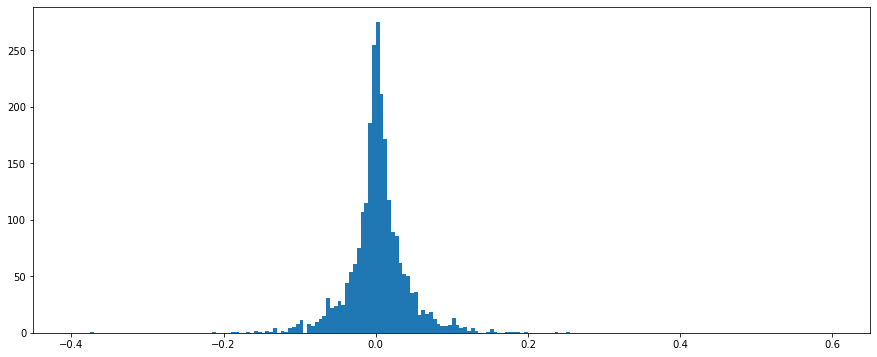

In [23]:
plt.figure(figsize = (15,6))
plt.hist(returns.btc, bins=200 , range=(-0.4, 0.6), label='Distribution of Bitcoin daily returns')

In [24]:
labels = 0
labels = pd.DataFrame(returns.btc)
labels['returns'] = returns.btc
labels = pd.concat([labels.returns, close.btc[close.btc.notnull()]], axis =1)
labels.rename(columns={'btc':'btc_close'}, inplace=True)
buy_cond = labels.returns > 0.017997 # returns.btc.describe()['75%']
sell_cond = labels.returns < -0.012599 # returns.btc.describe()['25%']

labels['c_label'] = 1
labels['c_label'] = labels['c_label'].mask(buy_cond, 2)
labels['c_label'] = labels['c_label'].mask(sell_cond, 0)

# Backtesting, used for later
labels['bkt_returns'] = 0
labels['bkt_returns'] = labels['bkt_returns'].mask(buy_cond, labels.returns)
labels['bkt_returns'] = labels['bkt_returns'].mask(sell_cond, labels.returns)
labels.head()
#labels.tail()

,returns,btc_close,c_label,bkt_returns
Date,,,,
2014-09-17,NaN,457.334015,1,0.000000
2014-09-18,-0.071926,424.440002,0,-0.071926
2014-09-19,-0.069843,394.795990,0,-0.069843
2014-09-20,0.035735,408.903992,2,0.035735
2014-09-21,-0.024659,398.821014,0,-0.024659


In [25]:
# row data cleaning
df.describe().loc['count'].min()

2442.0

# 2. Saving the basic Bitcoin dataset 

Now we can clean and save our basic dataset 

In [26]:
# adding to dataset close # close data build-up
close = pd.concat([close,labels['returns'],labels['c_label']], axis=1) 
close.rename(columns={'c_label':'SaleEqualBuy'}, inplace=True)
close.rename(columns={'spy':'S&P'}, inplace=True)
close.rename(columns={'returns':'returns%'}, inplace=True)
close.tail()

,Open,High,Low,Close,Volume,shangai,btc,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index,hashrate,difficulty,transactions,t_cost,btc_nbMyWallet,exchageVol,nbTransac,cost%,returns%,SaleEqualBuy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-17,38341.421875,39513.671875,37439.675781,38053.503906,3.709667e+10,3525.600098,38053.503906,71.040001,91.889999,1.199559,1773.800049,25.844000,421.970001,7153.399902,28558.589844,14161.349609,29018.330078,1.511,1.288124e+08,1.993279e+13,649773823.0,137.073657,NaN,5.274847e+08,237725.0,0.942244,-0.007655,1
2021-06-18,38099.476562,38187.261719,35255.855469,35787.246094,3.620089e+10,3525.100098,35787.246094,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450,1.228672e+08,1.993279e+13,650012711.0,133.942680,NaN,4.735432e+08,222918.0,0.579579,-0.059555,0
2021-06-19,35854.527344,36457.796875,34933.062500,35615.871094,3.120728e+10,3525.100098,35615.871094,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450,1.020590e+08,1.993279e+13,650235583.0,127.548037,NaN,4.923473e+08,187042.0,1.090928,-0.004789,1
2021-06-20,35563.140625,36059.484375,33432.074219,35698.296875,3.666403e+10,3525.100098,35698.296875,71.639999,92.230003,1.191341,1767.900024,25.958000,414.920013,7017.500000,28801.269531,14030.379883,28964.080078,1.450,1.040408e+08,1.993279e+13,650422399.0,141.962296,NaN,3.444704e+08,167249.0,1.097813,0.002314,1
2021-06-21,35687.859375,35687.859375,33892.687500,34460.886719,3.851328e+10,3519.493652,34460.886719,71.900002,92.268997,1.187085,1769.699951,25.639999,414.920013,7017.500000,28355.289062,14030.379883,27885.990234,1.450,NaN,NaN,NaN,NaN,NaN,4.679906e+08,NaN,NaN,-0.034663,0


In [27]:
#cleansing the data
close = close[-int(close.describe().loc['count'].min()):]
close.fillna(method='ffill', inplace=True)
close.shape # close.describe()

(2443, 28)

In [28]:
import datetime
yesterday = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
yesterday 

'2021-06-20'

In [29]:
# Save the data [The value of today is kept but not meaningful as the data is incomplete]
close.to_csv('data/L3_Data_Closing_v1.0-2014-09-18-to-' + yesterday + '.csv')
# Check the correlations
td = close.corr()['btc']
# close.shape # close.describe()
# Create correlation matrix
corr_mat = close.corr(method='pearson')['btc'] 
# Convert correlation matrix to 1-D Series and sort
corr_mat.sort_values()

dixie                          -0.415340
Treasury_Yield_10Years_Index   -0.306656
cost%                          -0.176692
SaleEqualBuy                   -0.009224
returns%                        0.018821
ftse                            0.034600
shangai                         0.173359
crude oil                       0.241624
nbTransac                       0.344137
euro                            0.460712
hsi                             0.461987
exchageVol                      0.481572
gold                            0.674922
transactions                    0.715511
silver                          0.737794
hashrate                        0.762458
difficulty                      0.768472
btc_nbMyWallet                  0.787429
Volume                          0.798139
S&P                             0.841788
nikkei                          0.848857
nasdaq                          0.854375
t_cost                          0.911072
Open                            0.998577
Low             

## Correlation heatmap 
For the fun let's see the correlation heatmap

<AxesSubplot:>

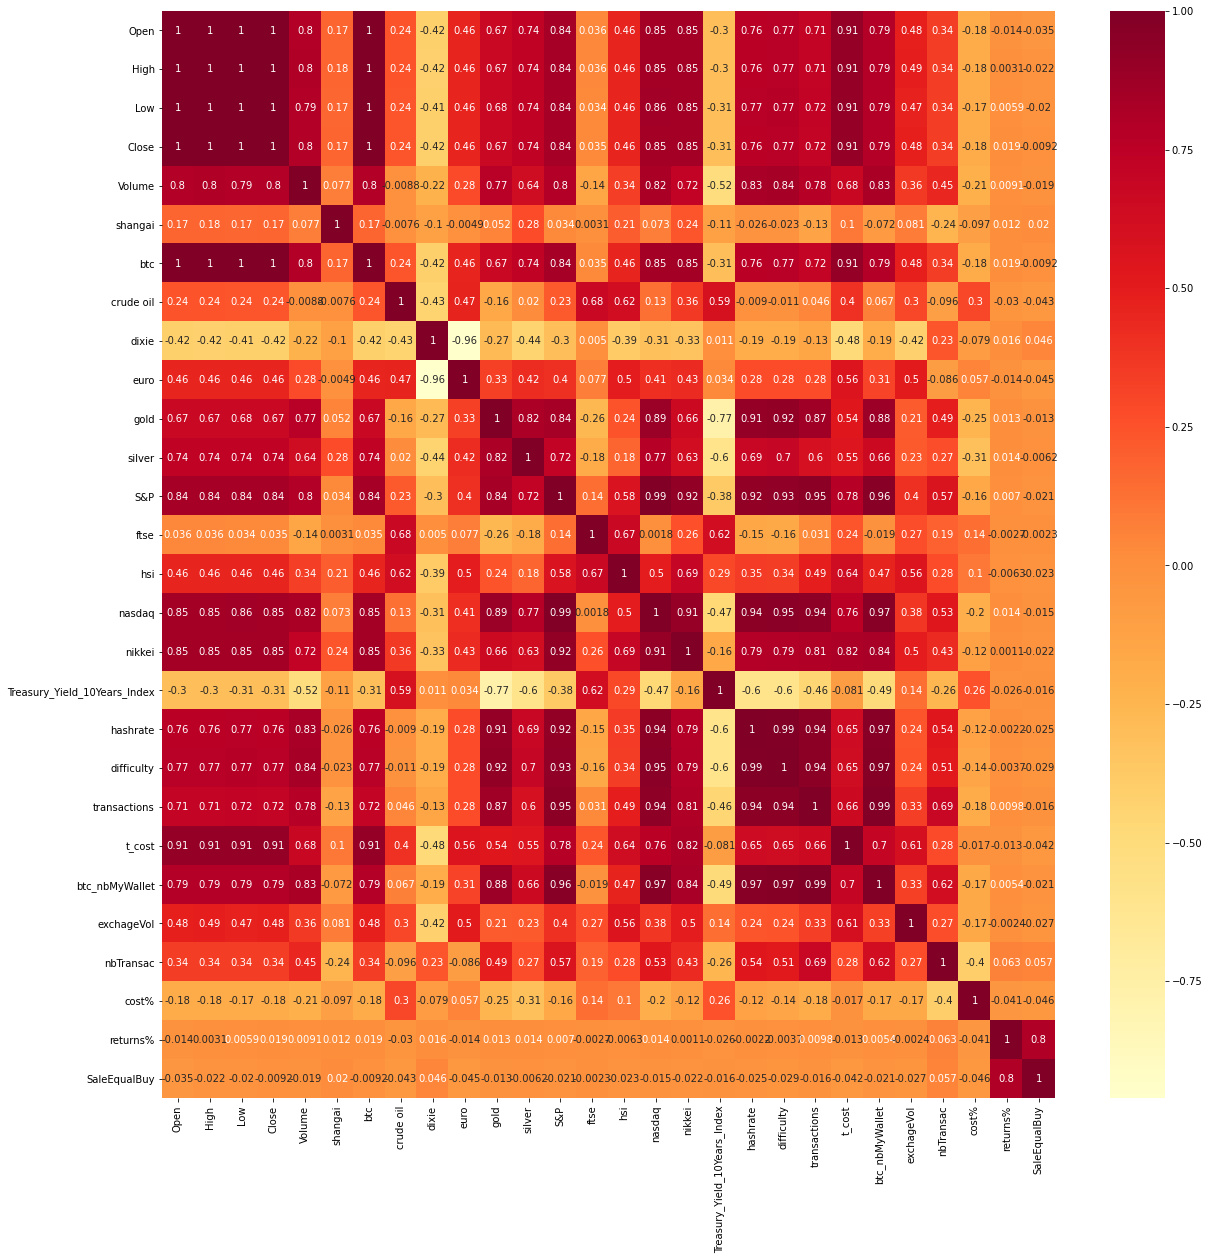

In [30]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(close.corr(), 
        xticklabels=close.corr().columns,
        yticklabels=close.corr().columns, ax=ax,
            annot=True, 
            cmap="YlOrRd")
# to change colors >> https://matplotlib.org/stable/tutorials/colors/colormaps.html

# 3. Saving the Nomalised Datasets 

We prepare now a second dataset with normalized values for neural network training purposers

#### Data cleaning

We consider the minimal available records as starting point and select the training data. Dates afterwards will be test data. We will also get rid of NA values that aren't useful for our analysis.

In [31]:
df = pd.concat([df,labels], axis=1) 
df.rename(columns={'btc':'btc_cumulative'}, inplace=True)

df = df[-int(df.describe().loc['count'].min()):]
df.describe()

,Open,High,Low,Close,Volume,shangai,btc_cumulative,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index,MA4,MA96,MA200,stochRSI,RSI,btc_std_dev,std_dif,hashrate,difficulty,transactions,t_cost,btc_nbMyWallet,exchageVol,nbTransac,cost%,returns,btc_close,c_label,bkt_returns
count,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2.441000e+03,2.441000e+03,2.441000e+03,2441.000000,2.415000e+03,2.442000e+03,2441.000000,2441.000000,2442.000000,2442.000000,2442.000000,2442.000000
mean,16.968012,17.367586,16.919400,17.313354,615.601751,1.370811,17.313354,0.552374,1.127244,0.880207,1.115371,0.947442,1.325029,1.014017,1.057395,1.609630,1.320314,0.770893,7892.904430,7058.769073,6018.952420,52.327495,55.664620,0.037285,7914.200788,4.531308e+07,6.264787e+12,3.079718e+08,42.541048,2.649974e+07,2.629501e+08,246584.429742,1.361982,0.002601,7917.985757,1.000000,0.001445
std,25.530993,26.203900,25.308012,26.026954,942.898964,0.170397,26.026954,0.120790,0.039028,0.038172,0.193693,0.189926,0.286089,0.082546,0.123080,0.559942,0.204218,0.251307,11884.241687,10380.384933,7692.603256,35.221171,17.823935,0.002944,11912.193807,5.255737e+07,7.310853e+12,1.835846e+08,44.852687,2.056672e+07,4.167672e+08,81423.227340,0.757392,0.039196,11903.011215,0.705221,0.038834
min,0.379718,0.452249,0.379093,0.389437,0.280886,0.992436,0.389437,-0.398538,1.002952,0.801791,0.851264,0.628784,0.910884,0.736466,0.751529,0.923969,0.914646,0.191923,199.000000,237.000000,246.000000,0.000000,5.342375,0.031363,178.061070,2.295135e+05,3.500248e+10,4.892243e+07,3.442916,2.352582e+06,4.674808e+05,58963.000000,0.249675,-0.371695,178.102997,0.000000,-0.371695
25%,1.233641,1.237965,1.259445,1.257273,3.454104,1.263927,1.257273,0.481227,1.102243,0.853321,0.987119,0.832797,1.054869,0.951780,0.966754,1.119102,1.190616,0.630000,575.000000,467.000000,438.500000,20.627452,43.000983,0.034988,574.683619,1.443197e+06,1.993121e+11,1.363795e+08,8.853201,7.564898e+06,1.654053e+07,195404.000000,0.811084,-0.012412,574.993500,1.000000,0.000000
50%,9.902128,10.415401,9.880875,10.182787,198.779729,1.353795,10.182787,0.552214,1.132822,0.872006,1.041437,0.893559,1.310934,1.027858,1.063574,1.526593,1.301593,0.817308,4565.500000,4494.000000,4693.500000,52.206747,54.855701,0.038573,4600.988168,2.212568e+07,2.874674e+12,2.998575e+08,28.999409,2.324628e+07,1.116620e+08,254515.000000,1.183878,0.001976,4656.935059,1.000000,0.000000
75%,19.905558,20.144693,20.153931,20.286269,924.156682,1.452776,20.286269,0.631619,1.152627,0.909012,1.207793,0.956384,1.465866,1.082909,1.156951,1.787745,1.424894,0.926346,9271.000000,8886.250000,8733.000000,86.329913,68.632818,0.039142,9272.599128,8.954943e+07,1.275982e+13,4.662955e+08,55.557945,4.278092e+07,3.320596e+08,311022.000000,1.674308,0.017878,9277.600830,1.000000,0.000000
max,136.356860,138.544849,137.502078,138.855749,16667.677020,2.238557,138.855749,0.877039,1.219481,0.989396,1.661941,1.575202,2.118356,1.161719,1.360090,3.106872,1.917577,1.243846,62875.000000,54511.000000,43154.000000,100.000000,98.422025,0.046020,63503.418201,1.985140e+08,2.504649e+13,6.504224e+08,300.310549,7.406349e+07,5.352016e+09,490644.000000,5.719049,0.252472,63503.457031,2.000000,0.252472


In [32]:
df.head()

,Open,High,Low,Close,Volume,shangai,btc_cumulative,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index,MA4,MA96,MA200,stochRSI,RSI,btc_std_dev,std_dif,hashrate,difficulty,transactions,t_cost,btc_nbMyWallet,exchageVol,nbTransac,cost%,returns,btc_close,c_label,bkt_returns
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-15,0.860670,0.859140,0.859299,0.863205,1.199950,1.028501,0.863205,0.866130,1.005313,0.975303,1.007858,0.933130,0.928667,0.916044,0.949280,0.923969,0.948696,0.803846,391.0,368.0,311.0,90.568513,65.402857,0.040229,394.732781,260997.422884,3.500248e+10,48922428.0,20.826655,2352582.0,6.974276e+06,76257.0,2.905530,-0.015209,394.773010,0,-0.015209
2014-10-16,0.846852,0.851835,0.824606,0.836491,1.281771,1.021061,0.836491,0.875874,1.003542,0.989396,1.004942,0.931683,0.927871,0.913728,0.939471,0.924422,0.927603,0.828077,392.0,368.0,311.0,73.156583,55.603220,0.039810,382.516190,260997.422884,3.500248e+10,49122345.0,17.914009,2357177.0,7.556519e+06,71826.0,2.362730,-0.030947,382.556000,0,-0.030947
2014-10-17,0.821605,0.823365,0.829732,0.839120,0.645905,1.014425,0.839120,0.876403,1.005785,0.988066,1.003159,0.926003,0.938829,0.930599,0.944487,0.933420,0.914646,0.845769,390.0,368.0,311.0,74.517347,56.369074,0.039148,383.718848,294057.096449,3.500248e+10,49191819.0,23.759744,2361569.0,3.032030e+06,69474.0,2.520999,0.003142,383.757996,1,0.000000
2014-10-18,0.824223,0.844041,0.837649,0.855921,0.542191,1.014425,0.855921,0.876403,1.005785,0.988066,1.003159,0.926003,0.938829,0.930599,0.944487,0.933420,0.914646,0.845769,388.0,368.0,311.0,83.243688,61.280360,0.038753,391.403233,233157.697776,3.500248e+10,49143757.0,24.826121,2361569.0,1.463420e+06,66477.0,4.017722,0.020023,391.441986,2,0.020023
2014-10-19,0.839846,0.841437,0.854196,0.851776,0.280886,1.014425,0.851776,0.876403,1.005785,0.988066,1.003159,0.926003,0.938829,0.930599,0.944487,0.933420,0.914646,0.845769,387.0,368.0,311.0,75.309590,59.413655,0.038123,389.507867,233157.697776,3.500248e+10,49332926.0,16.989367,2370886.0,2.762915e+06,78443.0,2.831366,-0.004844,389.545990,1,0.000000


In [33]:
# Fill NAs
df.fillna(method='ffill', inplace=True)
df['returns_label'] = df['c_label']
df['c_label'] = df['c_label'].shift(-1)
df['r_label'] = df['btc_close'].shift(-1)
df.tail()

,Open,High,Low,Close,Volume,shangai,btc_cumulative,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index,MA4,MA96,MA200,stochRSI,RSI,btc_std_dev,std_dif,hashrate,difficulty,transactions,t_cost,btc_nbMyWallet,exchageVol,nbTransac,cost%,returns,btc_close,c_label,bkt_returns,returns_label,r_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-17,82.301746,84.399541,82.753880,83.207246,1761.743002,1.527627,83.207246,0.752383,1.084888,0.925651,1.436973,1.384772,2.101968,1.054934,1.171567,3.104068,1.826354,0.581154,39256.0,50074.0,42831.0,62.413141,52.775721,0.039249,38053.464657,1.288124e+08,1.993279e+13,649773823.0,137.073657,74063489.0,5.274847e+08,237725.0,0.942244,-0.007655,38053.503906,0.0,0.000000,1,35787.246094
2021-06-18,81.782399,81.566385,77.926926,78.251879,1719.201744,1.527410,78.251879,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,38149.0,49829.0,42912.0,29.895262,42.319170,0.039261,35787.206832,1.228672e+08,1.993279e+13,650012711.0,133.942680,74063489.0,4.735432e+08,222918.0,0.579579,-0.059555,35787.246094,1.0,-0.059555,0,35615.871094
2021-06-19,76.963505,77.872321,77.213448,77.877153,1482.052340,1.527410,77.877153,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,36951.0,49618.0,42996.0,27.519699,41.555276,0.039254,35615.831840,1.020590e+08,1.993279e+13,650235583.0,127.548037,74063489.0,4.923473e+08,187042.0,1.090928,-0.004789,35615.871094,1.0,0.000000,1,35698.296875
2021-06-20,76.338029,77.021542,73.895775,78.057384,1741.196861,1.527410,78.057384,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,36289.0,49398.0,43079.0,29.330928,42.137701,0.039246,35698.257629,1.040408e+08,1.993279e+13,650422399.0,141.962296,74063489.0,3.444704e+08,167249.0,1.097813,0.002314,35698.296875,0.0,0.000000,1,34460.886719
2021-06-21,76.605744,76.227767,74.913881,75.351681,1829.018606,1.524981,75.351681,0.761491,1.089362,0.916026,1.433652,1.373841,2.066849,1.034892,1.163227,3.075361,1.755087,0.557692,35391.0,49144.0,43154.0,10.078585,35.946857,0.039245,34460.847474,1.040408e+08,1.993279e+13,650422399.0,141.962296,74063489.0,4.679906e+08,167249.0,1.097813,-0.034663,34460.886719,NaN,-0.034663,0,NaN


## Correlation between all features and labels used

In [34]:
ndf, mindf, maxdf = min_max_scaler(df)
# Correlation of BTC with features
df.corr()['btc_cumulative']
# df.corr()['btc_close']

Open                            0.998577
High                            0.999387
Low                             0.999245
Close                           1.000000
Volume                          0.798105
shangai                         0.172993
btc_cumulative                  1.000000
crude oil                       0.242652
dixie                          -0.416855
euro                            0.462106
gold                            0.674871
silver                          0.737831
S&P                             0.841824
ftse                            0.034385
hsi                             0.461868
nasdaq                          0.854389
nikkei                          0.849048
Treasury_Yield_10Years_Index   -0.306607
MA4                             0.998793
MA96                            0.938517
MA200                           0.896559
stochRSI                        0.014665
RSI                             0.028927
btc_std_dev                     0.301573
std_dif         

<AxesSubplot:>

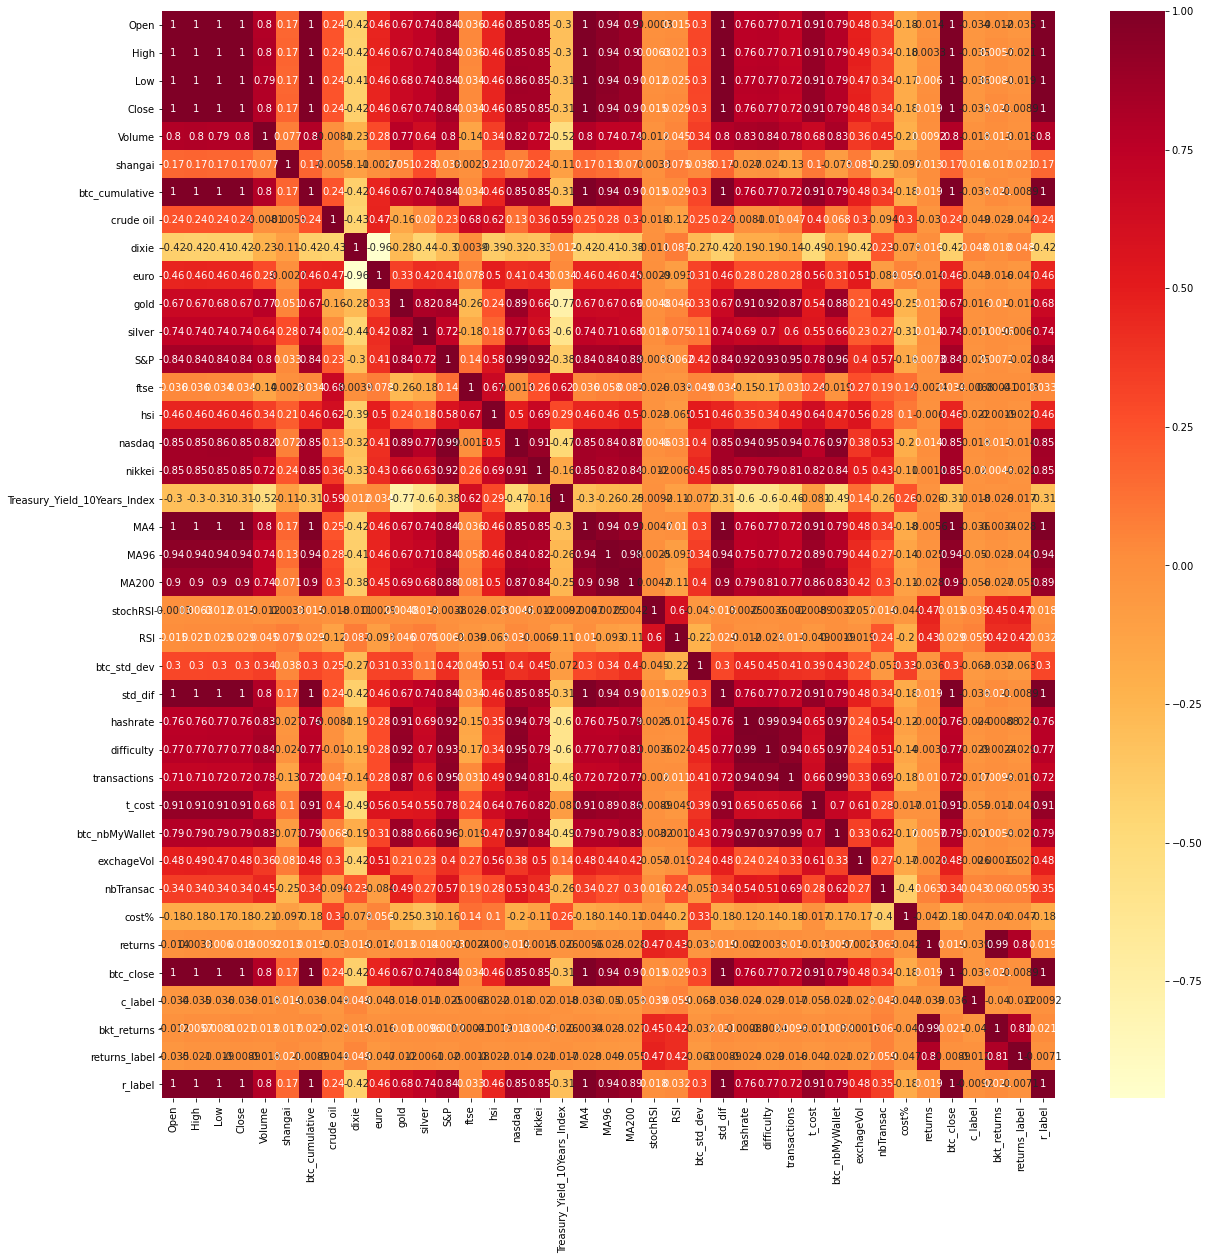

In [35]:
# Normalized correlation does not change, uncomment below to see
# ndf.corr()['btc']
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, ax=ax,
            annot=True, 
            cmap="YlOrRd")
# to change colors >> https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [36]:
# Description of normalized features
print(ndf.shape)
ndf.describe()

(2442, 39)


,Open,High,Low,Close,Volume,shangai,btc_cumulative,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index,MA4,MA96,MA200,stochRSI,RSI,btc_std_dev,std_dif,hashrate,difficulty,transactions,t_cost,btc_nbMyWallet,exchageVol,nbTransac,cost%,returns,btc_close,c_label,bkt_returns,returns_label,r_label
count,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2441.000000,2442.000000,2442.000000,2441.000000
mean,0.121993,0.122493,0.120624,0.122224,0.036918,0.303642,0.122224,0.745476,0.574022,0.417985,0.325786,0.336698,0.342985,0.652673,0.502605,0.314105,0.404482,0.550392,0.122810,0.125782,0.134664,0.523909,0.540862,0.404204,0.122224,0.227489,0.249301,0.430905,0.131839,0.337093,0.049048,0.434555,0.203350,0.599674,0.122224,0.500205,0.597821,0.500000,0.122273
std,0.187759,0.189756,0.184564,0.187966,0.056571,0.136742,0.187966,0.094695,0.180242,0.203468,0.238928,0.200679,0.236932,0.194111,0.202248,0.256513,0.203621,0.238902,0.189467,0.191117,0.179161,0.352327,0.191440,0.200730,0.187966,0.265074,0.292449,0.305366,0.151207,0.287435,0.077878,0.188617,0.138454,0.062798,0.187966,0.352538,0.062218,0.352611,0.187989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006280,0.005690,0.006420,0.006267,0.000190,0.217869,0.006267,0.689700,0.458561,0.274669,0.167583,0.215564,0.119245,0.506320,0.353662,0.089392,0.275164,0.416453,0.005999,0.004307,0.004533,0.207164,0.404667,0.248071,0.006268,0.006127,0.006569,0.145504,0.018229,0.073736,0.003003,0.315869,0.102669,0.575621,0.006267,0.500000,0.595506,0.500000,0.006268
50%,0.070029,0.072148,0.069294,0.070727,0.011909,0.289987,0.070727,0.745350,0.599782,0.374269,0.234586,0.279766,0.331312,0.685220,0.512758,0.276065,0.385816,0.594516,0.070386,0.078813,0.103943,0.522440,0.532420,0.492061,0.070727,0.110428,0.113535,0.417207,0.086153,0.289541,0.020778,0.452976,0.170772,0.598672,0.070727,0.500000,0.595506,0.500000,0.071461
75%,0.143596,0.142603,0.144212,0.143694,0.055430,0.369418,0.143694,0.807601,0.691249,0.571521,0.439792,0.346147,0.459623,0.814676,0.666198,0.395701,0.508756,0.698172,0.144792,0.159395,0.197958,0.863666,0.680197,0.530740,0.143694,0.450812,0.508759,0.694267,0.175701,0.563415,0.061962,0.583889,0.260385,0.624150,0.143694,0.500000,0.595506,0.500000,0.143700
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Splitting the data for training and testing

We take as training data from beginning of time until 2018, and test data from 2018-01-01 onwards.

<AxesSubplot:title={'center':'BTC price (log scale)'}, xlabel='Date'>

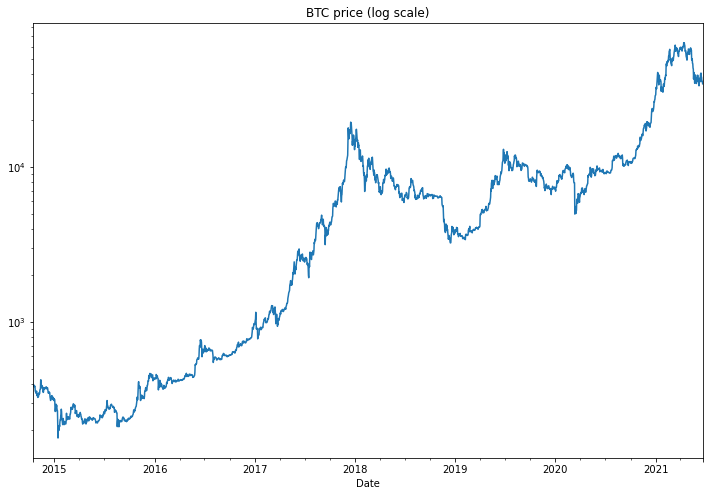

In [37]:
df.btc_close.loc[:].plot(figsize=(12,8), logy=True, title='BTC price (log scale)')

In [38]:
train_x = df.loc[:'2018-01-01']
train_nx = ndf.loc[:'2018-01-01']

test_x = df.loc['2018-01-01':]
test_nx = ndf.loc['2018-01-01':]

# Dropping last column of test (since they are shifted)
test_x.drop(test_x.index[-1], inplace=True)
test_nx.drop(test_nx.index[-1], inplace=True)

# Create labels for regression (price forecast) and classification (trading prediction)
train_y = train_x[['r_label', 'c_label']]
train_ny = train_nx[['r_label', 'c_label']]

test_y = test_x[['r_label', 'c_label']]
test_ny = test_nx[['r_label', 'c_label']]

test_x.tail()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Open,High,Low,Close,Volume,shangai,btc_cumulative,crude oil,dixie,euro,gold,silver,S&P,ftse,hsi,nasdaq,nikkei,Treasury_Yield_10Years_Index,MA4,MA96,MA200,stochRSI,RSI,btc_std_dev,std_dif,hashrate,difficulty,transactions,t_cost,btc_nbMyWallet,exchageVol,nbTransac,cost%,returns,btc_close,c_label,bkt_returns,returns_label,r_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-16,86.224070,86.542133,84.381474,83.849137,1862.183955,1.524477,83.849137,0.764139,1.075915,0.935799,1.506400,1.489578,2.102665,1.059594,1.166572,3.077399,1.843516,0.603462,39517.0,50316.0,42732.0,67.058738,54.269575,0.039257,38347.023243,1.218763e+08,1.993279e+13,649521585.0,125.644496,74063489.0,5.636397e+08,252937.0,0.811084,-0.050963,38347.062500,1.0,-0.050963,0,38053.503906
2021-06-17,82.301746,84.399541,82.753880,83.207246,1761.743002,1.527627,83.207246,0.752383,1.084888,0.925651,1.436973,1.384772,2.101968,1.054934,1.171567,3.104068,1.826354,0.581154,39256.0,50074.0,42831.0,62.413141,52.775721,0.039249,38053.464657,1.288124e+08,1.993279e+13,649773823.0,137.073657,74063489.0,5.274847e+08,237725.0,0.942244,-0.007655,38053.503906,0.0,0.000000,1,35787.246094
2021-06-18,81.782399,81.566385,77.926926,78.251879,1719.201744,1.527410,78.251879,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,38149.0,49829.0,42912.0,29.895262,42.319170,0.039261,35787.206832,1.228672e+08,1.993279e+13,650012711.0,133.942680,74063489.0,4.735432e+08,222918.0,0.579579,-0.059555,35787.246094,1.0,-0.059555,0,35615.871094
2021-06-19,76.963505,77.872321,77.213448,77.877153,1482.052340,1.527410,77.877153,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,36951.0,49618.0,42996.0,27.519699,41.555276,0.039254,35615.831840,1.020590e+08,1.993279e+13,650235583.0,127.548037,74063489.0,4.923473e+08,187042.0,1.090928,-0.004789,35615.871094,1.0,0.000000,1,35698.296875
2021-06-20,76.338029,77.021542,73.895775,78.057384,1741.196861,1.527410,78.057384,0.758738,1.088902,0.919310,1.432194,1.390880,2.066849,1.034892,1.181522,3.075361,1.822939,0.557692,36289.0,49398.0,43079.0,29.330928,42.137701,0.039246,35698.257629,1.040408e+08,1.993279e+13,650422399.0,141.962296,74063489.0,3.444704e+08,167249.0,1.097813,0.002314,35698.296875,0.0,0.000000,1,34460.886719


In [39]:
# Drop labels and unneeded columns on train & test feature data sets
drop_list = ['r_label','c_label','bkt_returns']
drop_df = [train_x, train_nx, test_x, test_nx]

for x in drop_df:
    x.drop(columns=drop_list, inplace=True)
#     x['ts'] = x['Date'].datetime.astype('int64') // 10**9
#     x.set_index('ts')
#     x.drop(columns=['ts'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [40]:
# Storing original and normalized data in CSVs
store_list = [train_x, train_nx, test_x, test_nx, train_y, train_ny, test_y, test_ny]
# !mkdir data
store_name = ['data/train_x.csv', 'data/train_nx.csv', 'data/test_x.csv', 'data/test_nx.csv', 'data/train_y.csv', 'data/train_ny.csv', 'data/test_y.csv', 'data/test_ny.csv']

for i in range(len(store_list)):
    store_list[i].to_csv(store_name[i])

## Recap 
### What was done?

#### We started by obtaining and preprocessing the data, specifically:

    Used Quandl and yfinance to source stock market, currencies and Bitcoin fundamentals.
    Calculated technical analysis indicators, such as simple moving averages, relative strength index (RSI), stochastic RSI, cumulated standard deviation and distance to prices.
    Labelled data necessary to provide trading signal predictions later. These labels were selected according to the historical distribution of daily Bitcoin returns.
    Created a heatmap to have an initial feeling of correlation between features.
    Cleaned up the data sets for NA values and stored training and testing data.

